In [1]:
%reload_ext autoreload

%autoreload 2

In [2]:
%reload_ext autoreload

%autoreload 2

In [3]:
INPUT_FILE = "../../test_data/system_tests/diaPASEF_diann/report.tsv.top3added.tsv"

DIRECTLFQ_FILE_PRECURSORS_MS1_MS2 = "../../test_data/system_tests/diaPASEF_diann/report.tsv.top3added.tsv.diann_precursor_ms1_and_ms2.protein_intensities.tsv"
DIRECTLFQ_FILE_PRECURSORS = "../../test_data/system_tests/diaPASEF_diann/report.tsv.top3added.tsv.diann_precursors.protein_intensities.tsv"
DIRECTLFQ_FILE_FRAGIONS_TOP3 = "../../test_data/system_tests/diaPASEF_diann/report.tsv.top3added.tsv.diann_fragion_isotopes_topn.protein_intensities.tsv"
DIRECTLFQ_FILE_FRAGIONS = "../../test_data/system_tests/diaPASEF_diann/report.tsv.top3added.tsv.diann_precursor_ms1_and_ms2.protein_intensities.tsv"

OUTPUT_FILE_PRECURSORS_MS1_MS2 = "../../test_data/system_tests/diaPASEF_diann/precursors_ms1_ms2.pdf"
OUTPUT_FILE_PRECURSORS = "../../test_data/system_tests/diaPASEF_diann/precursors.pdf"
OUTPUT_FILE_PRECURSORS_FRAGION_TOP3 = "../../test_data/system_tests/diaPASEF_diann/precursors_fragion_top3.pdf"
OUTPUT_FILE_FRAGION= "../../test_data/system_tests/diaPASEF_diann/fragion.pdf"

diann_protein_intensities = "../../test_data/system_tests/diaPASEF_diann/report.tsv.diann_protein.aq_reformat.tsv"
iq_protein_intensities = "../../test_data/system_tests/diaPASEF_diann/report_iq_results.tsv"

samplemap  = "../../test_data/system_tests/diaPASEF_diann/samplemap.tsv"

run_directlfq = False
run_protein_reformating = False

In [4]:
if run_protein_reformating:
    import directlfq.utils as lfq_utils
    lfq_utils.import_data(input_file=INPUT_FILE, input_type_to_use="diann_protein")

In [5]:
if run_directlfq:
    import directlfq.lfq_manager as lfqmgr
    input_types_to_use  = ["diann_fragion_isotopes_topn", "diann_precursor_ms1_and_ms2", "diann_precursors", "diann_fragion_isotopes"]
    for input_type in input_types_to_use:
        lfqmgr.run_lfq(input_file=INPUT_FILE, input_type_to_use=input_type, min_nonan=1)


In [6]:
import directlfq.benchmarking as lfqbenchmark
import directlfq.utils as lfqutils


samples_used = lfqutils.get_samples_used_from_samplemap_file(samplemap, cond1="45ng", cond2="15ng")


restable_directlfq_ms1_and_ms2 = lfqbenchmark.ResultsTableDirectLFQ(input_file=DIRECTLFQ_FILE_PRECURSORS_MS1_MS2, input_name="directLFQ", samples_c1=samples_used[0], samples_c2=samples_used[1])
restable_directlfq_precursors = lfqbenchmark.ResultsTableDirectLFQ(input_file=DIRECTLFQ_FILE_PRECURSORS, input_name="directLFQ", samples_c1=samples_used[0], samples_c2=samples_used[1])
restable_directlfq_fragions = lfqbenchmark.ResultsTableDirectLFQ(input_file=DIRECTLFQ_FILE_FRAGIONS, input_name="directLFQ", samples_c1=samples_used[0], samples_c2=samples_used[1])
restable_directlfq_fragions_top3 = lfqbenchmark.ResultsTableDirectLFQ(input_file=DIRECTLFQ_FILE_FRAGIONS_TOP3, input_name="directLFQ", samples_c1=samples_used[0], samples_c2=samples_used[1])

restable_diann = lfqbenchmark.ResultsTableDirectLFQ(input_file=diann_protein_intensities, input_name="DIANN", samples_c1=samples_used[0], samples_c2=samples_used[1])

restables = [restable_diann, restable_directlfq_ms1_and_ms2, restable_directlfq_precursors, restable_directlfq_fragions, restable_directlfq_fragions_top3]
restable_names = ["MaxLFQ DIANN", "directLFQ (precursors, MS1+MS2)", "directLFQ (precursors)", "directLFQ (fragions)", "directLFQ (fragions top3)"]

/Users/constantin/workspace/directlfq/directlfq/benchmarking.py:153: RuntimeWarning: divide by zero encountered in log2
  self.formated_dataframe[self.log2fc_column] = [np.log2(x[0]) - np.log2(x[1]) for x in zip(self.formated_dataframe['median_intensity_c1'], self.formated_dataframe['median_intensity_c2'])]
/Users/constantin/workspace/directlfq/directlfq/benchmarking.py:153: RuntimeWarning: invalid value encountered in double_scalars
  self.formated_dataframe[self.log2fc_column] = [np.log2(x[0]) - np.log2(x[1]) for x in zip(self.formated_dataframe['median_intensity_c1'], self.formated_dataframe['median_intensity_c2'])]
/Users/constantin/workspace/directlfq/directlfq/benchmarking.py:153: RuntimeWarning: divide by zero encountered in log2
  self.formated_dataframe[self.log2fc_column] = [np.log2(x[0]) - np.log2(x[1]) for x in zip(self.formated_dataframe['median_intensity_c1'], self.formated_dataframe['median_intensity_c2'])]
/Users/constantin/workspace/directlfq/directlfq/benchmarking.py:

In [7]:
display(restable_directlfq_ms1_and_ms2.formated_dataframe)
display(restable_diann.formated_dataframe)

,protein,200113_AUR_diaPASEF_HY_200ng_15ng_90min_Slot1-5_1_1630,200113_AUR_diaPASEF_HY_200ng_15ng_90min_Slot1-5_1_1635,200113_AUR_diaPASEF_HY_200ng_15ng_90min_Slot1-5_1_1636,200113_AUR_diaPASEF_HY_200ng_45ng_90min_Slot1-6_1_1637,200113_AUR_diaPASEF_HY_200ng_45ng_90min_Slot1-6_1_1638,200113_AUR_diaPASEF_HY_200ng_45ng_90min_Slot1-6_1_1639,Protein.Group,Protein.Names,Genes,median_intensity_c1,median_intensity_c2,log2fc,mean_intensity
0,A0A024RBG1,1.034403e+04,1.013323e+04,1.054452e+04,1.114191e+04,1.018799e+04,9.355987e+03,A0A024RBG1,NUD4B_HUMAN,NUDT4B,1.018799e+04,1.034403e+04,-0.021929,1.026601e+04
1,A0A087X1C5;P10635,2.483098e+05,3.956839e+05,3.971505e+05,3.946501e+05,4.364509e+05,4.111804e+05,A0A087X1C5;P10635,CP2D6_HUMAN;CP2D7_HUMAN,CYP2D6;CYP2D7,4.111804e+05,3.956839e+05,0.055423,4.034321e+05
2,A0A096LP01,2.033099e+04,2.151003e+04,2.275119e+04,2.469771e+04,2.748049e+04,2.253897e+04,A0A096LP01,SIM26_HUMAN,SMIM26,2.469771e+04,2.151003e+04,0.199368,2.310387e+04
3,A0A096LP49,5.257713e+04,4.893173e+04,5.237348e+04,4.866675e+04,4.820463e+04,4.919115e+04,A0A096LP49,CC187_HUMAN,CCDC187,4.866675e+04,5.237348e+04,-0.105900,5.052011e+04
4,A0A0A0MS06,0.000000e+00,1.718302e+03,0.000000e+00,8.002640e+02,0.000000e+00,0.000000e+00,A0A0A0MS06,TVB23_HUMAN,TRBV23-1,0.000000e+00,0.000000e+00,NaN,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13230,Q9Y6X9,1.942253e+05,1.998800e+05,2.049183e+05,1.965261e+05,1.912352e+05,1.974915e+05,Q9Y6X9,MORC2_HUMAN,MORC2,1.965261e+05,1.998800e+05,-0.024414,1.982031e+05
13231,Q9Y6Y0,2.002304e+05,1.939845e+05,2.004772e+05,2.000663e+05,2.001686e+05,1.995280e+05,Q9Y6Y0,NS1BP_HUMAN,IVNS1ABP,2.000663e+05,2.002304e+05,-0.001183,2.001484e+05
13232,Q9Y6Y1,5.194327e+03,5.741123e+03,6.318165e+03,6.169658e+03,5.622611e+03,5.285737e+03,Q9Y6Y1,CMTA1_HUMAN,CAMTA1,5.622611e+03,5.741123e+03,-0.030093,5.681867e+03
13233,Q9Y6Y8,1.516794e+06,1.574579e+06,1.582542e+06,1.529173e+06,1.520680e+06,1.534853e+06,Q9Y6Y8,S23IP_HUMAN,SEC23IP,1.529173e+06,1.574579e+06,-0.042214,1.551876e+06


,protein,ion,200113_AUR_diaPASEF_HY_200ng_15ng_90min_Slot1-5_1_1630,200113_AUR_diaPASEF_HY_200ng_15ng_90min_Slot1-5_1_1635,200113_AUR_diaPASEF_HY_200ng_15ng_90min_Slot1-5_1_1636,200113_AUR_diaPASEF_HY_200ng_45ng_90min_Slot1-6_1_1637,200113_AUR_diaPASEF_HY_200ng_45ng_90min_Slot1-6_1_1638,200113_AUR_diaPASEF_HY_200ng_45ng_90min_Slot1-6_1_1639,median_intensity_c1,median_intensity_c2,log2fc,mean_intensity
0,A0A024RBG1,NUD4B_HUMAN,6159.84,4920.65,4981.35,5215.960,5281.15,4410.20,5215.96,4981.35,0.066396,5098.655
1,A0A087X1C5;P10635,CP2D6_HUMAN;CP2D7_HUMAN,15189.90,25235.00,26034.00,28170.200,31520.60,27364.60,28170.20,25235.00,0.158744,26702.600
2,A0A096LP01,SIM26_HUMAN,6353.56,5788.88,6697.90,6471.690,7252.20,5446.35,6471.69,6353.56,0.026577,6412.625
3,A0A096LP49,CC187_HUMAN,5556.84,5021.14,5065.70,4979.910,4911.69,5347.48,4979.91,5065.70,-0.024642,5022.805
4,A0A0A0MS06,TVB23_HUMAN,0.00,1144.11,0.00,706.311,0.00,0.00,0.00,0.00,NaN,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...
13387,Q9Y6X9,MORC2_HUMAN,12186.80,12778.70,13018.40,12418.800,12179.80,12772.50,12418.80,12778.70,-0.041215,12598.750
13388,Q9Y6Y0,NS1BP_HUMAN,18379.00,17594.60,18546.20,19119.700,18357.00,18218.80,18357.00,18379.00,-0.001728,18368.000
13389,Q9Y6Y1,CMTA1_HUMAN,3019.10,3057.11,3413.48,3870.190,3599.03,3420.69,3599.03,3057.11,0.235440,3328.070
13390,Q9Y6Y8,S23IP_HUMAN,95530.40,97374.70,97009.00,98278.300,94674.60,96028.80,96028.80,97009.00,-0.014651,96518.900


In [8]:
organism_annotator_diann_based = lfqbenchmark.OrganismAnnotatorDIANN(mapping_file=INPUT_FILE)
for restable in restables:
    organism_annotator_diann_based.annotate_table_with_organism(restable)


In [9]:
import seaborn as sns
import directlfq.visualizations as lfq_viz

class MultiOrganismMultiMethodBoxPlotAdapted(lfq_viz.MultiOrganismMultiMethodBoxPlot):
    def plot_boxplot(self):
        color_palette = sns.color_palette(self._colorlist_hex, n_colors=len(self._fcs_to_expect))
        sns.boxplot(data=self._method_ratio_results_table, x="method", y = "log2fc", hue= "organism", palette=color_palette, hue_order=self._organisms_to_plot, ax=self.ax, linewidth=0.8)


In [10]:
import numpy as np
class MultiOrganismIntensityFCPlotter():
    def __init__(self, ax, resultstable_w_ratios, organisms_to_plot = None, fcs_to_expect = None, title = ""):
        print('init MultiOrganismIntensityFCPlotter')
        self.ax = ax
        self._color_list_hex = ['#ffd479', '#325e7a', '#bad566']
        self._resultstable_w_ratios = resultstable_w_ratios
        self._organism_column = resultstable_w_ratios.organism_column
        self._log2fc_column = resultstable_w_ratios.log2fc_column
        self._mean_intensity_column = resultstable_w_ratios.mean_intensity_column
        
        self._organisms_to_plot = self._get_organisms_to_plot(organisms_to_plot)
        self._fcs_to_expect = fcs_to_expect

        self._title = self._get_title(title)
        self._scatter_per_organism()
        self._add_expected_lines()

    def _get_organisms_to_plot(self, organisms_to_plot):
        if organisms_to_plot is not None:
            return organisms_to_plot
        else:
            return sorted(list(set(self._resultstable_w_ratios.formated_dataframe[self._organism_column].astype('str'))))
    
    def _get_title(self, title):
        if title !="":
            self._print_infos_about_data()
            return title
        return self._generate_title()

    def _print_infos_about_data(self):
        for organism in self._organisms_to_plot:
            subtable_organism = self._get_organism_subtable(organism)
            print(self._get_stats_of_organism(organism, subtable_organism))

    def _generate_title(self):
        for organism in self._organisms_to_plot:
            subtable_organism = self._get_organism_subtable(organism)
            title += self._get_stats_of_organism(organism, subtable_organism)
        return title

    def _scatter_per_organism(self):
        complete_table = self._resultstable_w_ratios.formated_dataframe.copy()
        complete_table[self._mean_intensity_column] = np.log2(complete_table[self._mean_intensity_column])
        complete_table = self._remove_omitted_organisms_from_table(complete_table)
        color_palette = sns.color_palette(self._color_list_hex, n_colors=len(self._organisms_to_plot))
        sns.scatterplot(data= complete_table, x =self._mean_intensity_column, y= self._log2fc_column, hue=self._organism_column, alpha=0.15, ax=self.ax, 
        hue_order=self._organisms_to_plot, palette=color_palette, size=0.2)
        self.ax.set_title(self._title)
    
    def _remove_omitted_organisms_from_table(self, complete_table):
        row_w_permitted_organism = [x in self._organisms_to_plot for x in complete_table["organism"]]
        return complete_table[row_w_permitted_organism]

    def _add_expected_lines(self):
        if self._fcs_to_expect is not None:
            for idx, fc in enumerate(self._fcs_to_expect):
                color = self._color_list_hex[idx]
                self.ax.axhline(fc, color = color)

    def _get_organism_subtable(self, organism):
        complete_table = self._resultstable_w_ratios.formated_dataframe
        return complete_table[complete_table[self._organism_column] == organism]
    
    def _get_stats_of_organism(self, organism, subtable_organism):
        fcs = subtable_organism[self._log2fc_column].to_numpy()
        fcs = fcs[np.isfinite(fcs)]
        median_fc = np.nanmedian(fcs)
        std_fc = np.nanstd(fcs)
        num_ratios = sum(~np.isnan(fcs))
        return f"{organism} num:{num_ratios} median_FC:{median_fc:.2} STD:{std_fc:.2}\n"

In [11]:
display(restable_directlfq_ms1_and_ms2.formated_dataframe)

,protein,200113_AUR_diaPASEF_HY_200ng_15ng_90min_Slot1-5_1_1630,200113_AUR_diaPASEF_HY_200ng_15ng_90min_Slot1-5_1_1635,200113_AUR_diaPASEF_HY_200ng_15ng_90min_Slot1-5_1_1636,200113_AUR_diaPASEF_HY_200ng_45ng_90min_Slot1-6_1_1637,200113_AUR_diaPASEF_HY_200ng_45ng_90min_Slot1-6_1_1638,200113_AUR_diaPASEF_HY_200ng_45ng_90min_Slot1-6_1_1639,Protein.Group,Protein.Names,Genes,median_intensity_c1,median_intensity_c2,log2fc,mean_intensity,organism
0,A0A024RBG1,1.034403e+04,1.013323e+04,1.054452e+04,1.114191e+04,1.018799e+04,9.355987e+03,A0A024RBG1,NUD4B_HUMAN,NUDT4B,1.018799e+04,1.034403e+04,-0.021929,1.026601e+04,HUMAN
1,A0A087X1C5;P10635,2.483098e+05,3.956839e+05,3.971505e+05,3.946501e+05,4.364509e+05,4.111804e+05,A0A087X1C5;P10635,CP2D6_HUMAN;CP2D7_HUMAN,CYP2D6;CYP2D7,4.111804e+05,3.956839e+05,0.055423,4.034321e+05,HUMAN
2,A0A096LP01,2.033099e+04,2.151003e+04,2.275119e+04,2.469771e+04,2.748049e+04,2.253897e+04,A0A096LP01,SIM26_HUMAN,SMIM26,2.469771e+04,2.151003e+04,0.199368,2.310387e+04,HUMAN
3,A0A096LP49,5.257713e+04,4.893173e+04,5.237348e+04,4.866675e+04,4.820463e+04,4.919115e+04,A0A096LP49,CC187_HUMAN,CCDC187,4.866675e+04,5.237348e+04,-0.105900,5.052011e+04,HUMAN
4,A0A0A0MS06,0.000000e+00,1.718302e+03,0.000000e+00,8.002640e+02,0.000000e+00,0.000000e+00,A0A0A0MS06,TVB23_HUMAN,TRBV23-1,0.000000e+00,0.000000e+00,NaN,0.000000e+00,HUMAN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13230,Q9Y6X9,1.942253e+05,1.998800e+05,2.049183e+05,1.965261e+05,1.912352e+05,1.974915e+05,Q9Y6X9,MORC2_HUMAN,MORC2,1.965261e+05,1.998800e+05,-0.024414,1.982031e+05,HUMAN
13231,Q9Y6Y0,2.002304e+05,1.939845e+05,2.004772e+05,2.000663e+05,2.001686e+05,1.995280e+05,Q9Y6Y0,NS1BP_HUMAN,IVNS1ABP,2.000663e+05,2.002304e+05,-0.001183,2.001484e+05,HUMAN
13232,Q9Y6Y1,5.194327e+03,5.741123e+03,6.318165e+03,6.169658e+03,5.622611e+03,5.285737e+03,Q9Y6Y1,CMTA1_HUMAN,CAMTA1,5.622611e+03,5.741123e+03,-0.030093,5.681867e+03,HUMAN
13233,Q9Y6Y8,1.516794e+06,1.574579e+06,1.582542e+06,1.529173e+06,1.520680e+06,1.534853e+06,Q9Y6Y8,S23IP_HUMAN,SEC23IP,1.529173e+06,1.574579e+06,-0.042214,1.551876e+06,HUMAN


MaxLFQ DIANN
YEAST num:3275 median_FC:1.5 STD:0.39

HUMAN num:9159 median_FC:0.012 STD:0.15

directLFQ (precursors, MS1+MS2)
YEAST num:3273 median_FC:1.4 STD:0.39

HUMAN num:9158 median_FC:-0.023 STD:0.15

directLFQ (precursors)
YEAST num:3273 median_FC:1.4 STD:0.39

HUMAN num:9158 median_FC:-0.025 STD:0.15

directLFQ (fragions)
YEAST num:3273 median_FC:1.4 STD:0.39

HUMAN num:9158 median_FC:-0.023 STD:0.15

directLFQ (fragions top3)
YEAST num:3274 median_FC:1.4 STD:0.38

HUMAN num:9159 median_FC:-0.026 STD:0.15



/Users/constantin/opt/anaconda3/envs/directlfq/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/constantin/opt/anaconda3/envs/directlfq/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/constantin/opt/anaconda3/envs/directlfq/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/constantin/opt/anaconda3/envs/directlfq/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/constantin/opt/anaconda3/envs/directlfq/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result

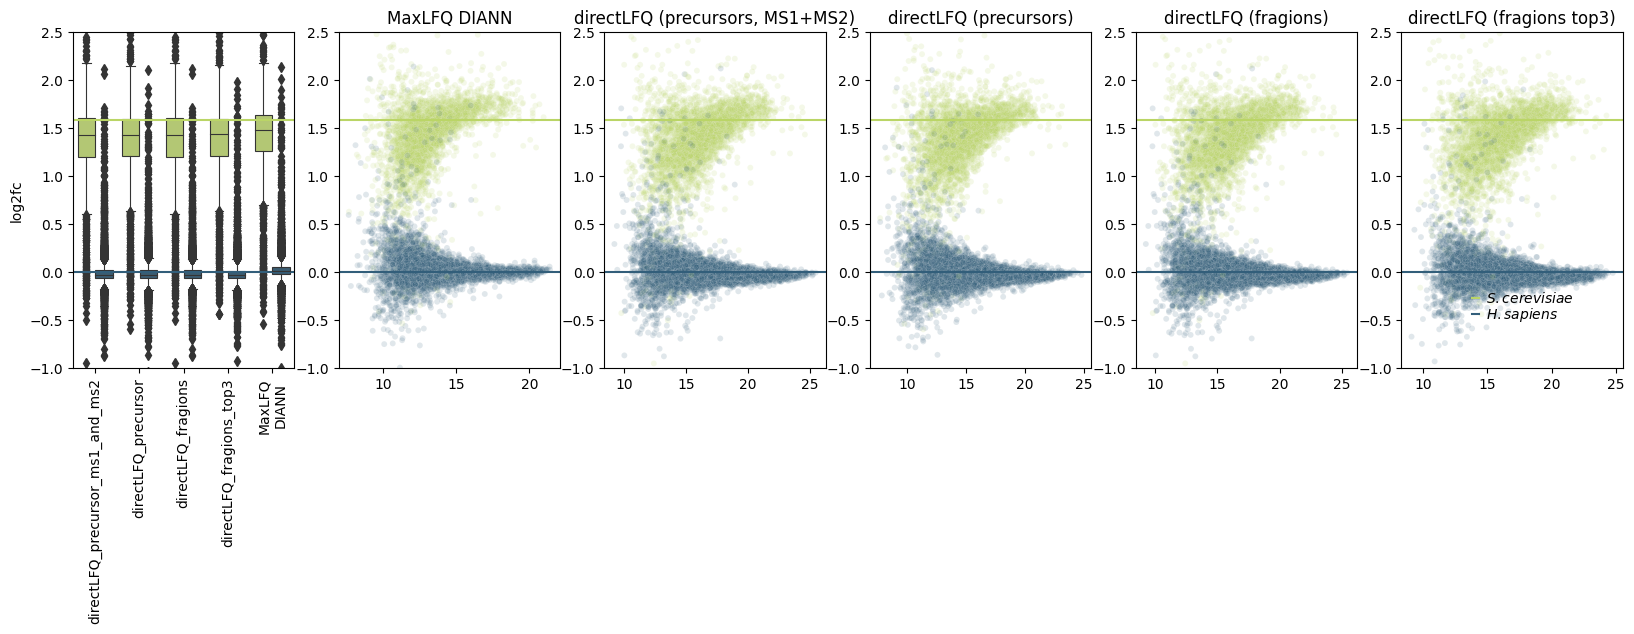

In [12]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import directlfq.benchmarking




methodname2resultsdf = {'directLFQ_precursor_ms1_and_ms2' : restable_directlfq_ms1_and_ms2.formated_dataframe, 'directLFQ_precursor' : restable_directlfq_precursors.formated_dataframe,
                        'directLFQ_fragions' : restable_directlfq_fragions.formated_dataframe, 'directLFQ_fragions_top3' : restable_directlfq_fragions_top3.formated_dataframe,
                        'MaxLFQ\nDIANN' : restable_diann.formated_dataframe}

num_results = len(restables)
a4_dims = (11.7, 8.27)
a4_width_no_margin = 10.5
fig, axes = plt.subplots(1, num_results+1,figsize=(4*num_results,4.363 ))

organisms_to_plot = [ "YEAST", "HUMAN"]
fcs_to_expect = [  np.log2(3), 0]

merged_table = directlfq.benchmarking.ResultsTableMerger(method_name2results_df=methodname2resultsdf).merged_table


MultiOrganismMultiMethodBoxPlotAdapted(method_ratio_results_table=merged_table, ax = axes[0], organisms_to_plot=organisms_to_plot,fcs_to_expect= fcs_to_expect)


for idx in range(num_results):
    restable = restables[idx]
    name = restable_names[idx]
    print(name)
    directlfq.benchmarking.MultiOrganismIntensityFCPlotter(ax=axes[idx+1], resultstable_w_ratios=restable, organisms_to_plot = organisms_to_plot, fcs_to_expect= fcs_to_expect, title=name)




for ax in axes:
    ax.get_legend().remove()

for ax in axes[1:]:
    ax.set_ylabel("")

for ax in axes:
    ax.set_xlabel("mean intensity")
axes[0].set_xlabel("")
for idx in range(num_results+1):
    if idx>0:
        axes[idx].set_xlabel("")
    axes[idx].set_ylim([-1, 2.5])

#rotate xticklabels of first plot
for tick in axes[0].get_xticklabels():
    tick.set_rotation(90)


lines = axes[1].get_lines()
#axes[1].legend(lines, ["S. cerevisiae", "H. sapiens", "C. elegans"], loc='upper left', bbox_to_anchor=(1, 1))
fig.legend(lines, ["$S. cerevisiae$", "$H. sapiens$"], bbox_to_anchor=[0.85, 0.25], 
           loc='center', ncol=1, title = None, frameon = False, labelspacing = 0, handlelength = 0.5, handletextpad = 0.5)
#change label type in legend



In [47]:
import pandas as pd
diann_df = pd.read_csv(input_file, sep="\t")

NameError: name 'input_file' is not defined

In [159]:

def go_through_diann_frame_and_add_top_n_fragment_intensities(diann_df, n):
    all_fragment_intensities = []
    diann_precursorgrouped = diann_df.groupby('Precursor.Id')
    for _,diann_df_precursor_subset in diann_precursorgrouped:
       fragment_intensities = get_topn_fragment_intensities(diann_df_precursor_subset, n)
       all_fragment_intensities+=fragment_intensities
    
    diann_df["Fragment.Intensities.topN"] = all_fragment_intensities
    return diann_df
        

def get_topn_fragment_intensities(diann_df_precursor_subset, n):
    idxs_of_n_ions = get_idxs_of_n_most_correlating_fragments(diann_df_precursor_subset, n)
    intensities = diann_df_precursor_subset["Fragment.Quant.Corrected"].values
    intensities = [np.fromstring(x, dtype=float, sep=';')[idxs_of_n_ions] for x in intensities]
    #merge array to string
    intensities = [np.array2string(x, separator=";").replace(" ","").replace("[","").replace("]","")+";" for x in intensities]
    return intensities

def get_idxs_of_n_most_correlating_fragments(diann_df_precursor_subset, n):
    split_vals = diann_df_precursor_subset["Fragment.Correlations"].values
    split_vals = [np.fromstring(x, dtype=float, sep=';') for x in split_vals]
    median = np.median(split_vals, axis=0)
    idxs = np.argsort(median)[::-1][:n]
    return idxs



In [160]:
diann_df_w_topn = go_through_diann_frame_and_add_top_n_fragment_intensities(diann_df, 3)

In [164]:
diann_df_w_topn = diann_df_w_topn.rename(columns={"Fragment.Intensities.topN" : "Fragment.Quant.Corrected.topN"})

In [165]:
diann_df_w_topn.to_csv(input_file +".top3added.tsv", sep="\t", index=False)

In [163]:
display(diann_df_w_topn.head(5))

,File.Name,Run,Protein.Group,Protein.Ids,Protein.Names,Genes,PG.Quantity,PG.Normalised,PG.MaxLFQ,Genes.Quantity,...,Decoy.CScore,Fragment.Quant.Raw,Fragment.Quant.Corrected,Fragment.Correlations,MS2.Scan,IM,iIM,Predicted.IM,Predicted.iIM,Fragment.Intensities.topN
0,E:\Patricia\two_species_HY\200113_AUR_diaPASEF...,200113_AUR_diaPASEF_HY_200ng_45ng_90min_Slot1-...,A0A3B3IS91,A0A3B3IS91,PLGRF_HUMAN,POLGARF,36.0019,36.2507,36.2507,36.0019,...,4.570500e-01,51.0019;0;22.001;9.00049;18.001;9.00049;0;0;0;...,51.0019;0;22.001;9.00049;18.001;9.00049;0;0;0;...,0.408248;0;0;0.816497;0.866025;0.816497;0;0;0;...,115545,1.13625,1.125,1.12567,1.13544,18.001;9.00049;9.00049;
1,E:\Patricia\two_species_HY\200113_AUR_diaPASEF...,200113_AUR_diaPASEF_HY_200ng_15ng_90min_Slot1-...,P37108,P37108,SRP14_HUMAN,SRP14,296534.0000,297079.0000,287737.0000,296534.0000,...,-1.000000e+07,590.03;1656.1;415.028;136.008;374.03;0;167.011...,590.03;1656.1;415.028;136.008;374.03;0;167.011...,0.8453;0.973939;0.869558;0.774177;0.776877;0;0...,47519,1.39052,1.395,1.39531,1.39028,1656.1;590.03;374.03;
2,E:\Patricia\two_species_HY\200113_AUR_diaPASEF...,200113_AUR_diaPASEF_HY_200ng_15ng_90min_Slot1-...,P37108,P37108,SRP14_HUMAN,SRP14,316952.0000,298203.0000,298777.0000,316952.0000,...,-1.000000e+07,751.05;1584.09;72.0041;100.005;370.027;0;22.00...,751.05;1584.09;72.0041;100.005;370.027;0;22.00...,0.960734;0.966977;0.709863;0.381586;0.945913;0...,48351,1.39239,1.395,1.39586,1.39144,1584.09;751.05;370.027;
3,E:\Patricia\two_species_HY\200113_AUR_diaPASEF...,200113_AUR_diaPASEF_HY_200ng_15ng_90min_Slot1-...,P37108,P37108,SRP14_HUMAN,SRP14,318861.0000,303760.0000,304468.0000,318861.0000,...,-1.000000e+07,1543.09;2276.16;621.041;376.022;649.044;19.001...,1543.09;2276.16;621.041;376.022;649.044;19.001...,0.94234;0.990281;0.974596;0.936803;0.903717;0....,48383,1.39500,1.395,1.39677,1.39306,2276.16;1543.09;649.044;
4,E:\Patricia\two_species_HY\200113_AUR_diaPASEF...,200113_AUR_diaPASEF_HY_200ng_45ng_90min_Slot1-...,P37108,P37108,SRP14_HUMAN,SRP14,290082.0000,301268.0000,304725.0000,290082.0000,...,9.532450e-03,1137.06;2117.11;163.012;385.022;531.035;54.002...,1137.06;2117.11;163.012;385.022;531.035;54.002...,0.837838;0.849611;0.710362;0.811958;0.936291;0...,48287,1.39409,1.395,1.39629,1.39253,2117.11;1137.06;531.035;


In [151]:


df = pd.DataFrame(np.arange(1,10).reshape(3,3),
                  columns = list('abc'),
                  index=pd.Series([2,5,5], name='b'))
display(df)
display(df.index)
#increment by 1 for each occurence of the index
display(df.groupby(df.index).aggregate())

,a,b,c
b,,,
2,1,2,3
5,4,5,6
5,7,8,9


Int64Index([2, 5, 5], dtype='int64', name='b')

TypeError: Must provide 'func' or tuples of '(column, aggfunc).

In [70]:
diann_df.loc['AAAAAAAAAAAAAAATAASAAASAILGGR3']["Fragment.Correlations"]

'0.408248;0;0;0.816497;0.866025;0.816497;0;0;0;0;0;0;'

In [99]:
split_vals = diann_df.loc[['AAAAAAAAAPAAAATAPTTAATTAATAAQ2']]["Fragment.Correlations"].values
split_vals = [np.fromstring(x, dtype=float, sep=';') for x in split_vals]
summed = np.median(split_vals, axis=0)
idxs = np.argsort(summed)[::-1][:3]
print(idxs)

[1 0 4]


In [125]:
intensities = diann_df.loc[['AAAAAAAAAPAAAATAPTTAATTAATAAQ2']]["Fragment.Quant.Corrected"].values
print(intensities)
intensities = [np.fromstring(x, dtype=float, sep=';')[[0, 1, 2]] for x in intensities]

print(intensities)
#merge array to string

intensities = [np.array2string(x, separator=";").replace(" ","").replace("[","").replace("]","")+";" for x in intensities]

print(intensities)

['590.03;1656.1;415.028;136.008;374.03;0;167.011;0;0;152.008;0;'
 '751.05;1584.09;72.0041;100.005;370.027;0;22.0014;80.0055;0;83.0041;78.0054;'
 '1543.09;2276.16;621.041;376.022;649.044;19.0014;79.0041;0;9.0007;106.005;82.0055;'
 '1137.06;2117.11;163.012;385.022;531.035;54.0027;194.011;0;9.00067;111.007;0;'
 '1380.09;2664.17;918.05;280.019;768.052;263.019;46.0034;0;0;189.014;59.0027;'
 '1356.08;2204.13;530.033;300.022;722.037;80.0061;270.019;90.0054;0;192.009;0;']
[array([ 590.03 , 1656.1  ,  415.028]), array([ 751.05  , 1584.09  ,   72.0041]), array([1543.09 , 2276.16 ,  621.041]), array([1137.06 , 2117.11 ,  163.012]), array([1380.09, 2664.17,  918.05]), array([1356.08 , 2204.13 ,  530.033])]
['590.03;1656.1;415.028;', '751.05;1584.09;72.0041;', '1543.09;2276.16;621.041;', '1137.06;2117.11;163.012;', '1380.09;2664.17;918.05;', '1356.08;2204.13;530.033;']


In [97]:

print(summed)
#get indexes of n highest values

print(idxs)


[0.9416535 0.979264  0.8673255 0.7863655 0.923906  0.460625  0.823607
 0.        0.        0.756697  0.254235 ]
[1 0 4]


In [82]:
diann_df.loc[['AAAAAAAAAPAAAATAPTTAATTAATAAQ2']]["Fragment.Correlations"].values[0].split(";")

['0.8453',
 '0.973939',
 '0.869558',
 '0.774177',
 '0.776877',
 '0',
 '0.896884',
 '0',
 '0',
 '0.770424',
 '0',
 '']

,File.Name,Run,Protein.Group,Protein.Ids,Protein.Names,Genes,PG.Quantity,PG.Normalised,PG.MaxLFQ,Genes.Quantity,...,Decoy.Evidence,Decoy.CScore,Fragment.Quant.Raw,Fragment.Quant.Corrected,Fragment.Correlations,MS2.Scan,IM,iIM,Predicted.IM,Predicted.iIM
Precursor.Id,,,,,,,,,,,,,,,,,,,,,
AAAAAAAAAAAAAAATAASAAASAILGGR3,E:\Patricia\two_species_HY\200113_AUR_diaPASEF...,200113_AUR_diaPASEF_HY_200ng_45ng_90min_Slot1-...,A0A3B3IS91,A0A3B3IS91,PLGRF_HUMAN,POLGARF,36.0019,36.2507,36.2507,36.0019,...,1.057950,4.570500e-01,51.0019;0;22.001;9.00049;18.001;9.00049;0;0;0;...,51.0019;0;22.001;9.00049;18.001;9.00049;0;0;0;...,0.408248;0;0;0.816497;0.866025;0.816497;0;0;0;...,115545,1.136250,1.125000,1.125670,1.135440
AAAAAAAAAPAAAATAPTTAATTAATAAQ2,E:\Patricia\two_species_HY\200113_AUR_diaPASEF...,200113_AUR_diaPASEF_HY_200ng_15ng_90min_Slot1-...,P37108,P37108,SRP14_HUMAN,SRP14,296534.0000,297079.0000,287737.0000,296534.0000,...,0.000000,-1.000000e+07,590.03;1656.1;415.028;136.008;374.03;0;167.011...,590.03;1656.1;415.028;136.008;374.03;0;167.011...,0.8453;0.973939;0.869558;0.774177;0.776877;0;0...,47519,1.390520,1.395000,1.395310,1.390280
AAAAAAAAAPAAAATAPTTAATTAATAAQ2,E:\Patricia\two_species_HY\200113_AUR_diaPASEF...,200113_AUR_diaPASEF_HY_200ng_15ng_90min_Slot1-...,P37108,P37108,SRP14_HUMAN,SRP14,316952.0000,298203.0000,298777.0000,316952.0000,...,0.000000,-1.000000e+07,751.05;1584.09;72.0041;100.005;370.027;0;22.00...,751.05;1584.09;72.0041;100.005;370.027;0;22.00...,0.960734;0.966977;0.709863;0.381586;0.945913;0...,48351,1.392390,1.395000,1.395860,1.391440
AAAAAAAAAPAAAATAPTTAATTAATAAQ2,E:\Patricia\two_species_HY\200113_AUR_diaPASEF...,200113_AUR_diaPASEF_HY_200ng_15ng_90min_Slot1-...,P37108,P37108,SRP14_HUMAN,SRP14,318861.0000,303760.0000,304468.0000,318861.0000,...,0.000000,-1.000000e+07,1543.09;2276.16;621.041;376.022;649.044;19.001...,1543.09;2276.16;621.041;376.022;649.044;19.001...,0.94234;0.990281;0.974596;0.936803;0.903717;0....,48383,1.395000,1.395000,1.396770,1.393060
AAAAAAAAAPAAAATAPTTAATTAATAAQ2,E:\Patricia\two_species_HY\200113_AUR_diaPASEF...,200113_AUR_diaPASEF_HY_200ng_45ng_90min_Slot1-...,P37108,P37108,SRP14_HUMAN,SRP14,290082.0000,301268.0000,304725.0000,290082.0000,...,0.799072,9.532450e-03,1137.06;2117.11;163.012;385.022;531.035;54.002...,1137.06;2117.11;163.012;385.022;531.035;54.002...,0.837838;0.849611;0.710362;0.811958;0.936291;0...,48287,1.394090,1.395000,1.396290,1.392530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YYYVQNVYTPVDEHVYPDHR4,E:\Patricia\two_species_HY\200113_AUR_diaPASEF...,200113_AUR_diaPASEF_HY_200ng_15ng_90min_Slot1-...,Q86TG7,Q86TG7,PEG10_HUMAN,PEG10,42847.2000,39677.2000,38978.0000,42847.2000,...,1.142910,9.263360e-04,3914.11;1648.04;2243.07;1235.04;498.013;688.02...,3914.11;1648.04;2243.07;1235.04;498.013;688.02...,0.982906;0.968287;0.93509;0.868805;0.906007;0....,52421,0.908646,0.896667,0.897203,0.908212
YYYVQNVYTPVDEHVYPDHR4,E:\Patricia\two_species_HY\200113_AUR_diaPASEF...,200113_AUR_diaPASEF_HY_200ng_15ng_90min_Slot1-...,Q86TG7,Q86TG7,PEG10_HUMAN,PEG10,38263.9000,35516.5000,38734.7000,38263.9000,...,0.482463,6.112600e-03,3402.1;1498.04;2393.07;1090.03;669.021;639.02;...,3402.1;1498.04;2393.07;1090.03;669.021;639.02;...,0.925207;0.821296;0.904237;0.988039;0.771057;0...,52453,0.909688,0.896667,0.897605,0.908759
YYYVQNVYTPVDEHVYPDHR4,E:\Patricia\two_species_HY\200113_AUR_diaPASEF...,200113_AUR_diaPASEF_HY_200ng_45ng_90min_Slot1-...,Q86TG7,Q86TG7,PEG10_HUMAN,PEG10,34916.9000,35879.0000,38609.5000,34916.9000,...,1.117580,5.738240e-03,2404.07;1739.05;2776.06;912.027;687.017;892.02...,2404.07;1739.05;2776.06;912.027;687.017;892.02...,0.949791;0.912688;0.932816;0.967806;0.903151;0...,52325,0.896667,0.896667,0.896975,0.896390


In [60]:
display(diann_df.columns)
display(diann_df['Fragment.Correlations'])

Index(['File.Name', 'Run', 'Protein.Group', 'Protein.Ids', 'Protein.Names',
       'Genes', 'PG.Quantity', 'PG.Normalised', 'PG.MaxLFQ', 'Genes.Quantity',
       'Genes.Normalised', 'Genes.MaxLFQ', 'Genes.MaxLFQ.Unique',
       'Modified.Sequence', 'Stripped.Sequence', 'Precursor.Id',
       'Precursor.Charge', 'Q.Value', 'PEP', 'Global.Q.Value',
       'Protein.Q.Value', 'PG.Q.Value', 'Global.PG.Q.Value', 'GG.Q.Value',
       'Translated.Q.Value', 'Proteotypic', 'Precursor.Quantity',
       'Precursor.Normalised', 'Precursor.Translated', 'Translated.Quality',
       'Ms1.Translated', 'Quantity.Quality', 'RT', 'RT.Start', 'RT.Stop',
       'iRT', 'Predicted.RT', 'Predicted.iRT', 'First.Protein.Description',
       'Lib.Q.Value', 'Lib.PG.Q.Value', 'Ms1.Profile.Corr', 'Ms1.Area',
       'Evidence', 'Spectrum.Similarity', 'Averagine', 'Mass.Evidence',
       'CScore', 'Decoy.Evidence', 'Decoy.CScore', 'Fragment.Quant.Raw',
       'Fragment.Quant.Corrected', 'Fragment.Correlations', 'MS2.S

0         0.408248;0;0;0.816497;0.866025;0.816497;0;0;0;...
1         0.8453;0.973939;0.869558;0.774177;0.776877;0;0...
2         0.960734;0.966977;0.709863;0.381586;0.945913;0...
3         0.94234;0.990281;0.974596;0.936803;0.903717;0....
4         0.837838;0.849611;0.710362;0.811958;0.936291;0...
                                ...                        
994308    0.982906;0.968287;0.93509;0.868805;0.906007;0....
994309    0.925207;0.821296;0.904237;0.988039;0.771057;0...
994310    0.949791;0.912688;0.932816;0.967806;0.903151;0...
994311    0.969243;0.932909;0.876834;0.931894;0.848609;0...
994312    0.990191;0.982611;0.922688;0.965664;0.85451;0....
Name: Fragment.Correlations, Length: 994313, dtype: object